# Three attributes game

Each action has 3 numerical atributes.  The three attributes are ranked for tiebreaking.  You win if your action is greater than the opponent's action in 2 out of 3 attributes.  In case that one attribute is tied, the tie is broken based on the rank of the winning attribute.

In the following, consider 3 non-negative integer attributes, each of which takes values {0, 1, 2, 3}.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# get all integer vectors with entries {0, ..., 4}
temp = np.ones((5, 5, 5))
vectors = np.array(np.nonzero(temp)).T
# restrict to vectors with sums in {1, .., 4}
sums = np.sum(vectors, 1)
vectors = vectors[np.logical_and(sums >= 1, sums <= 4)]
vectors

array([[0, 0, 1],
       [0, 0, 2],
       [0, 0, 3],
       [0, 0, 4],
       [0, 1, 0],
       [0, 1, 1],
       [0, 1, 2],
       [0, 1, 3],
       [0, 2, 0],
       [0, 2, 1],
       [0, 2, 2],
       [0, 3, 0],
       [0, 3, 1],
       [0, 4, 0],
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 2],
       [1, 0, 3],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 2],
       [1, 2, 0],
       [1, 2, 1],
       [1, 3, 0],
       [2, 0, 0],
       [2, 0, 1],
       [2, 0, 2],
       [2, 1, 0],
       [2, 1, 1],
       [2, 2, 0],
       [3, 0, 0],
       [3, 0, 1],
       [3, 1, 0],
       [4, 0, 0]])

In [3]:
# compute payoff sign matrix
a0_dom = np.sign(vectors[:, [0]] - vectors[:, [0]].T)
a1_dom = np.sign(vectors[:, [1]] - vectors[:, [1]].T)
a2_dom = np.sign(vectors[:, [2]] - vectors[:, [2]].T)

scores = 4 * (a0_dom > 0).astype(int) + 3 * (a1_dom > 0).astype(int) + 2 * (a2_dom > 0).astype(int)
win_mat = (scores > scores.T).astype(int)
p_sign = win_mat - win_mat.T



In [4]:
flag = True
# delete strictly dominating or dominant vectors
while flag:
    to_delete = np.logical_or(np.sum(p_sign == 1, 1) == 0, np.sum(p_sign == -1, 1) == 0)
    print(vectors[to_delete])
    vectors = vectors[~to_delete]
    p_sign = p_sign[~to_delete, :][:, ~to_delete]
    flag = (np.sum(to_delete) > 0)

[[0 0 1]]
[[0 0 2]]
[[0 0 3]]
[[0 0 4]]
[[0 1 0]]
[]


In [5]:
# check a few entries manually
i = 3
j = 5
print(vectors[[i, j], :])
p_sign[i, j]

[[0 2 0]
 [0 2 2]]


-1

In [6]:
# function to form payoff matrix from signs and rewards
def form_payoff(p_sign, rewards):
    payoff = np.dot(np.diag(rewards), (p_sign==1))
    payoff = payoff - payoff.T
    return payoff

In [7]:
# tune rewards
n = len(vectors)
# desired nash equilibrium
target_p = np.ones(n)/n

def tune_rewards(p_sign, target_p, learning_rate = 0.002, n_iterations = 50000):
    # uniform rewards to begin
    rewards = np.ones(len(p_sign))
    # determine values of strategies
    # decrease the rewards of high-value strategies and increase the rewards of low-value strategies
    all_rewards = []
    all_values = []

    for iter_no in range(n_iterations):
        all_rewards.append(rewards)
        payoff = form_payoff(p_sign, rewards)
        values = np.dot(payoff, target_p)
        all_values.append(values)
        rewards = rewards - learning_rate * values

    all_rewards = np.array(all_rewards)
    all_values = np.array(all_values)
    return rewards, values, all_rewards, all_values

In [8]:
rewards, values, all_rewards, all_values = tune_rewards(p_sign, target_p)

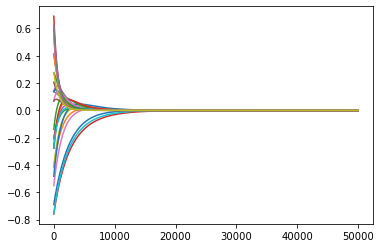

In [9]:
plt.plot(all_values)
plt.show()

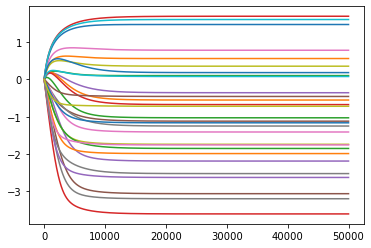

In [10]:
plt.plot(np.log(all_rewards))
plt.show()

In [11]:
np.sort(rewards)

array([0.02713487, 0.0407664 , 0.04668271, 0.07214853, 0.08001574,
       0.11199051, 0.13687728, 0.15698888, 0.17271508, 0.17554641,
       0.24417602, 0.28649216, 0.31243875, 0.32635748, 0.3573483 ,
       0.48676964, 0.50918235, 0.57538772, 0.63342359, 0.69997635,
       1.08132306, 1.1083493 , 1.20102559, 1.42596083, 1.75155702,
       2.1866904 , 4.36254705, 4.98574343, 5.44438452])

In [12]:
np.sort(rewards/np.min(rewards))

array([  1.        ,   1.50236231,   1.72039548,   2.65888622,
         2.94881625,   4.12718079,   5.04433164,   5.78550361,
         6.36506049,   6.46940312,   8.99860679,  10.55808136,
        11.51428997,  12.02723622,  13.16933948,  17.93889763,
        18.76487203,  21.20473512,  23.34352854,  25.79619408,
        39.84994549,  40.84594198,  44.26133696,  52.55086426,
        64.55004466,  80.58599367, 160.7727316 , 183.73935711,
       200.64163439])

In [13]:
# Select a subset with intermediate rewards
subset = np.logical_and(rewards > 0.2, rewards < 5.0)
np.sum(subset)

18

In [14]:
vectors_sub = vectors[subset, :]
p_sign_sub = p_sign[subset, :][:, subset]
rewards, values, all_rewards, all_values = tune_rewards(p_sign_sub, np.ones(len(p_sign_sub))/len(p_sign_sub))

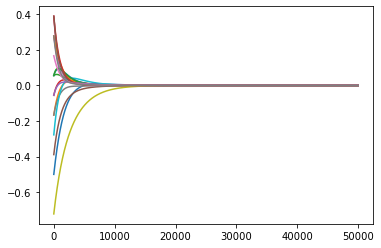

In [15]:
plt.plot(all_values)
plt.show()

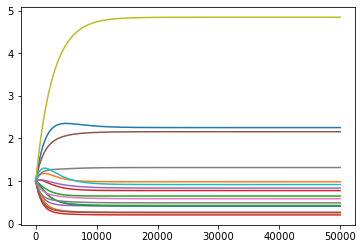

In [16]:
plt.plot(all_rewards)
plt.show()

In [17]:
# discretize rewards
d_rewards = np.floor(rewards/np.min(rewards) * 1)
probs = np.ones(len(p_sign_sub))/len(p_sign_sub)
payoff = form_payoff(p_sign_sub, d_rewards)

In [18]:
def evolve_strategy(payoff, probs, learning_rate = 0.0005, n_iterations = 1000000):

    all_probs = []
    all_values = []

    for iter_no in range(n_iterations):
        all_probs.append(probs)
        #probs = np.mean(all_probs, 0)
        #print(probs)
        values = np.dot(payoff, probs)
        all_values.append(values)
        probs = probs * (1 + learning_rate * values)
        probs = probs/np.sum(probs)

    all_probs = np.array(all_probs)
    all_values = np.array(all_values)
    probs = np.mean(all_probs[int(n_iterations/2):, :], 0)
    values = np.dot(payoff, probs)
    return probs, values, all_probs, all_values

In [19]:
probs, values, all_probs, all_values = evolve_strategy(payoff, probs, 0.0001, 1000000)

In [20]:
np.max(values), np.min(values)

(0.025453310320263767, -0.47747552474389887)

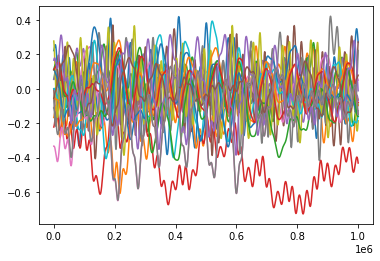

In [21]:
plt.plot(all_values)
plt.show()

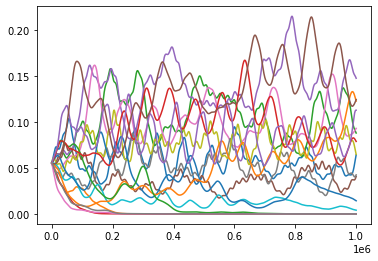

In [22]:
plt.plot(all_probs)
plt.show()

In [23]:
np.sum(probs > 0.01)

13

In [24]:
results = pd.DataFrame({
    'VP': d_rewards.astype(int), 
    'A0': vectors_sub[:, 0], 'A1': vectors_sub[:, 1], 'A2': vectors_sub[:, 2], 
    'total': np.sum(vectors_sub, 1),
    'prob': np.floor(probs* 1000)/10})
results.iloc[np.argsort(-probs)[:np.sum(probs > 0.01)], :].reset_index(drop = True)

,VP,A0,A1,A2,total,prob
0,1,2,0,1,3,15.0
1,2,0,2,2,4,14.2
2,3,0,1,3,4,10.5
3,1,0,3,1,4,9.9
4,1,1,2,0,3,9.8
5,4,2,0,0,2,8.1
6,24,1,0,0,1,7.9
7,1,1,0,3,4,6.9
8,11,0,1,1,2,5.5
9,6,0,4,0,4,4.9


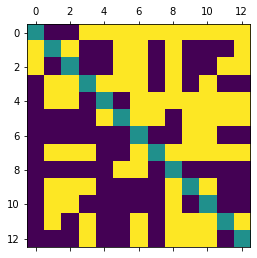

In [25]:
inds = np.argsort(-probs)[:np.sum(probs > 0.01)]
plt.matshow(p_sign_sub[inds, :][:, inds])